In [ ]:
# from sklearn.metrics import f1_score

In [1]:
import numpy as np
import pandas as pd

используем ВСЕ поля

Amount, Value и TransactionStartTime скейлим с помощью RobustScaler

Остальные поля - MinMaxScaler

In [2]:
df_trn = pd.read_csv('./data/training_le.csv')
df_tst = pd.read_csv('./data/test_le.csv')
df_sbm = pd.read_csv('./data/sample_submission.csv')

In [3]:
df_trn['TransactionStartTime'] = pd.to_datetime(df_trn['TransactionStartTime'])
df_tst['TransactionStartTime'] = pd.to_datetime(df_tst['TransactionStartTime'])

**Scaling**

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [5]:
columns4MinMaxScaler = [
    'BatchId',
    'AccountId', 
    'SubscriptionId', 
    'CustomerId', 
    'ProviderId',
    'ProductId', 
    'ProductCategory', 
    'ChannelId',
    'PricingStrategy'
]

In [6]:
# int --> float
for clm in columns4MinMaxScaler:
    df_trn[clm] = df_trn[clm].astype(float)
    df_tst[clm] = df_tst[clm].astype(float)

In [7]:
def scaleColumns(data, cols_to_scale, scaler):
    for col in cols_to_scale:
        data[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data[col])))
    return data

In [8]:
df_trn = scaleColumns(df_trn, columns4MinMaxScaler, MinMaxScaler())
df_tst = scaleColumns(df_tst, columns4MinMaxScaler, MinMaxScaler())

In [9]:
df_trn = scaleColumns(df_trn, ['Amount', 'Value', 'TransactionStartTime'], RobustScaler())
df_tst = scaleColumns(df_tst, ['Amount', 'Value', 'TransactionStartTime'], RobustScaler())

In [10]:
df_trn.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,0.258949,0.817355,0.183078,0.589061,1.0,0.346154,0.000000,0.50,0.000000,0.000000,-1.058573,0.666667,0
1,0.112122,1.000000,0.791684,0.589061,0.6,0.192308,0.222222,0.25,-0.357895,-0.207407,-1.058568,0.666667,0
2,0.386684,0.873554,0.045511,0.626103,1.0,0.000000,0.000000,0.50,-0.175439,-0.105820,-1.058171,0.666667,0
3,0.733818,0.133678,0.451593,0.131987,0.0,0.769231,1.000000,0.50,6.666667,4.402116,-1.057405,0.666667,0
4,0.277996,1.000000,0.791684,0.131987,0.6,0.192308,0.222222,0.25,-0.576842,-0.075344,-1.057382,0.666667,0


**Distributions**

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/abogatyrov/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


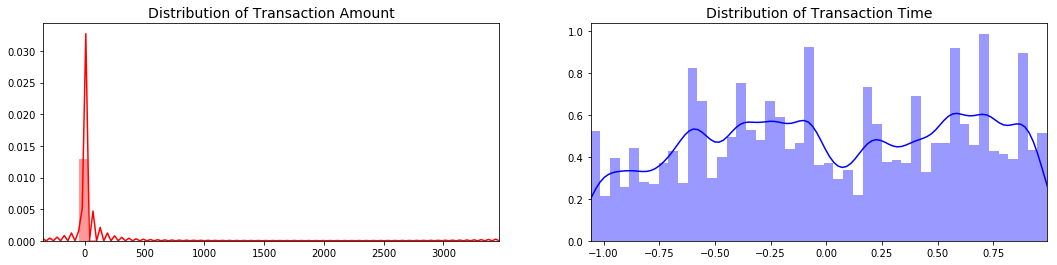

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df_trn['Amount'].values
time_val   = df_trn['TransactionStartTime'].astype('float').values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

## Prepare Original Dataset

In [18]:
print('No Frauds', round(df_trn['FraudResult'].value_counts()[0] / len(df_trn) * 100, 2), '% of the dataset')
print('Frauds',    round(df_trn['FraudResult'].value_counts()[1] / len(df_trn) * 100, 2), '% of the dataset')

No Frauds 99.8 % of the dataset
Frauds 0.2 % of the dataset


In [19]:
X = df_trn.drop('FraudResult', axis=1)
y = df_trn['FraudResult']

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [21]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [22]:
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [19127 19128 19129 ... 95659 95660 95661] Test: [    0     1     2 ... 22377 22820 23157]
Train: [    0     1     2 ... 95659 95660 95661] Test: [19127 19128 19129 ... 47285 48212 48287]
Train: [    0     1     2 ... 95659 95660 95661] Test: [38251 38252 38253 ... 70047 70051 70218]
Train: [    0     1     2 ... 95659 95660 95661] Test: [57373 57374 57375 ... 82314 82318 82333]
Train: [    0     1     2 ... 82314 82318 82333] Test: [76503 76504 76505 ... 95659 95660 95661]


In [23]:
# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

Check the Distribution of the labels

In [32]:
original_Xtrain[:5]

array([[ 0.25894861,  0.81735537,  0.1830782 ,  0.58906125,  1.        ,
         0.34615385,  0.        ,  0.5       ,  0.        ,  0.        ,
        -1.05857307,  0.66666667],
       [ 0.11212193,  1.        ,  0.79168391,  0.58906125,  0.6       ,
         0.19230769,  0.22222222,  0.25      , -0.35789474, -0.20740741,
        -1.05856808,  0.66666667],
       [ 0.38668445,  0.87355372,  0.04551096,  0.62610324,  1.        ,
         0.        ,  0.        ,  0.5       , -0.1754386 , -0.10582011,
        -1.05817051,  0.66666667],
       [ 0.73381795,  0.13367769,  0.45159288,  0.13198716,  0.        ,
         0.76923077,  1.        ,  0.5       ,  6.66666667,  4.4021164 ,
        -1.0574048 ,  0.66666667],
       [ 0.27799643,  1.        ,  0.79168391,  0.13198716,  0.6       ,
         0.19230769,  0.22222222,  0.25      , -0.57684211, -0.07534392,
        -1.0573822 ,  0.66666667]])

In [27]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [ ]:
original_Xtrain[:5]

In [34]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label,  test_counts_label  = np.unique(original_ytest,  return_counts=True)

print('Label Distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label  / len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99797468 0.00202532]
[0.9980137 0.0019863]


## Random Under Sampling

Предполагаем, что транзакции независимы (мешок транзакций)

In [35]:
# Lets shuffle the data before creating the subsamples
df_trn = df_trn.sample(frac=1)

In [36]:
# amount of fraud classes 193 rows.
df_fraud     = df_trn.loc[df_trn['FraudResult'] == 1]
df_non_fraud = df_trn.loc[df_trn['FraudResult'] == 0][:193]

In [38]:
df_under_sampling = pd.concat([df_fraud, df_non_fraud])

In [39]:
# Shuffle dataframe rows
df_rnd_under_sampling = df_under_sampling.sample(frac=1, random_state=24)

In [40]:
df_rnd_under_sampling.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
75202,0.290485,1.000000,0.791684,0.405590,0.6,0.192308,0.222222,0.25,-0.354386,-0.209524,0.612539,0.666667,0
55822,0.548028,0.877686,0.915805,0.981278,0.6,0.076923,0.000000,0.25,-316.140351,190.264550,0.225586,1.000000,1
30160,0.684919,0.065496,0.638188,0.086387,1.0,0.076923,0.000000,0.50,0.000000,0.000000,-0.329128,0.666667,0
34886,0.049100,0.110950,0.887671,0.116609,1.0,0.269231,0.888889,0.50,9.473684,5.714286,-0.235347,0.666667,0
94025,0.197683,0.968182,0.860157,0.689222,0.0,0.538462,0.222222,0.50,1038.245614,626.243386,0.954895,0.666667,1


In [42]:
print('Distribution of the Classes in the subsample dataset')
print(df_rnd_under_sampling['FraudResult'].value_counts() / len(df_rnd_under_sampling))

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: FraudResult, dtype: float64


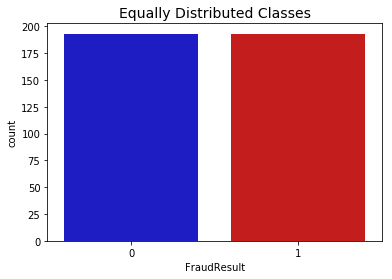

In [43]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('FraudResult', data=df_rnd_under_sampling, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [47]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label,  test_counts_label  = np.unique(original_ytest,  return_counts=True)

In [49]:
print('Label Distributions:')
print(train_counts_label / len(original_ytrain))
print(test_counts_label  / len(original_ytest))

Label Distributions:
[0.99797468 0.00202532]
[0.9980137 0.0019863]


### Dimensionality Reduction and Clustering

In [44]:
import time
import warnings
warnings.filterwarnings("ignore")

In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

In [50]:
# New_df is from the random undersample data (fewer instances)
X = df_rnd_under_sampling.drop('FraudResult', axis=1)
y = df_rnd_under_sampling['FraudResult']

In [51]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=24).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 1.2 s


In [53]:
# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=24).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

PCA took 0.0094 s


In [54]:
# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=24).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

Truncated SVD took 0.011 s


In [55]:
import matplotlib.patches as mpatches

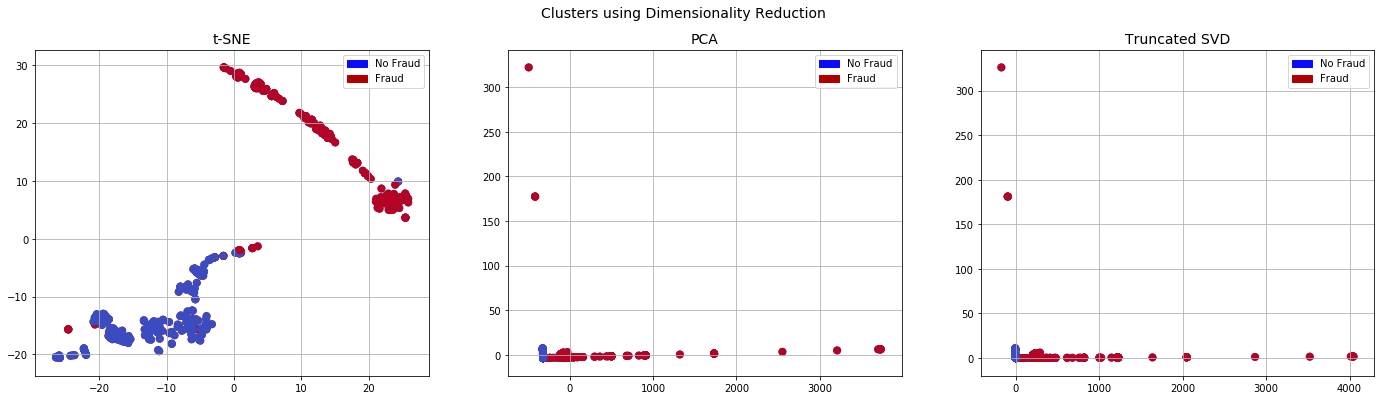

In [56]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch  = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# UnderSampling

In [57]:
# Undersampling before cross validating (prone to overfit)
X = df_rnd_under_sampling.drop('FraudResult', axis=1)
y = df_rnd_under_sampling['FraudResult']

In [58]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

In [59]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [ ]:
X_train.head()

In [60]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test  = X_test.values
y_train = y_train.values
y_test  = y_test.values

In [68]:
X_train[:5, ]

array([[ 3.27426142e-01,  9.61570248e-01,  4.22424493e-01,
         6.84942498e-01,  8.00000000e-01,  5.38461538e-01,
         2.22222222e-01,  5.00000000e-01,  2.80350877e+02,
         1.69100529e+02, -1.57920028e-01,  6.66666667e-01],
       [ 1.13383659e-01,  2.43181818e-01,  4.72900290e-01,
         2.05135063e-01,  0.00000000e+00,  5.38461538e-01,
         2.22222222e-01,  5.00000000e-01,  3.46280702e+03,
         2.08867725e+03,  8.44267335e-01,  6.66666667e-01],
       [ 3.38222538e-01,  6.97107438e-01,  7.27347952e-01,
         5.09093340e-01,  8.00000000e-01,  7.69230769e-01,
         1.00000000e+00,  5.00000000e-01,  6.66666667e+00,
         4.40211640e+00,  3.20481626e-01,  6.66666667e-01],
       [ 1.20724635e-02,  1.67561983e-01,  8.16921804e-01,
         1.54453062e-01,  1.00000000e+00,  6.92307692e-01,
         8.88888889e-01,  5.00000000e-01, -3.50877193e-02,
        -2.11640212e-02, -3.04050882e-01,  6.66666667e-01],
       [ 6.71606053e-01,  7.91528926e-01,  8.6036408

In [61]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

In [62]:
# Let's implement simple classifiers
classifiers = {
    'LogisiticRegression': LogisticRegression(),
    'KNearest': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [63]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score

In [64]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression has a training score of 98.0 % accuracy score
Classifiers:  KNeighborsClassifier has a training score of 97.0 % accuracy score
Classifiers:  SVC has a training score of 97.0 % accuracy score
Classifiers:  DecisionTreeClassifier has a training score of 98.0 % accuracy score


In [65]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

In [72]:
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [73]:
# k-Nears Neighbors Classifier
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

In [74]:
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

In [75]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"],
               "max_depth": list(range(2, 4, 1)),
               "min_samples_leaf": list(range(5, 7, 1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

### Overfitting Case

In [76]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  98.06%
Knears Neighbors Cross Validation Score 97.74%
Support Vector Classifier Cross Validation Score 97.74%
DecisionTree Classifier Cross Validation Score 97.74%


In [77]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter

In [79]:
# We will undersample during cross validating
undersample_X = df_trn.drop('FraudResult', axis=1)
undersample_y = df_trn['FraudResult']

In [80]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

Train: [18802 19134 19135 ... 95659 95660 95661] Test: [    0     1     2 ... 19131 19132 19133]
Train: [    0     1     2 ... 95659 95660 95661] Test: [18802 19134 19135 ... 44011 44653 44762]
Train: [    0     1     2 ... 95659 95660 95661] Test: [38251 38252 38253 ... 59439 59687 60202]
Train: [    0     1     2 ... 95659 95660 95661] Test: [57392 57393 57394 ... 76528 76529 77077]
Train: [    0     1     2 ... 76528 76529 77077] Test: [76530 76531 76532 ... 95659 95660 95661]


In [81]:
undersample_Xtrain.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
45644,0.601444,0.999793,0.791684,0.085183,0.6,0.192308,0.222222,0.25,-0.701754,0.000000,-0.064710,0.666667
66364,0.111971,0.554545,0.956558,0.415084,1.0,0.076923,0.000000,0.50,0.070175,0.042328,0.453483,0.666667
16290,0.989505,0.877686,0.915805,0.981813,0.6,0.076923,0.000000,0.25,-9.122807,5.079365,-0.613539,1.000000
18931,0.266010,0.501860,0.815887,0.380316,1.0,0.076923,0.000000,0.50,3.157895,1.904762,-0.554365,0.666667
63418,0.214716,1.000000,0.791684,0.528350,0.6,0.192308,0.222222,0.25,-0.368421,-0.201058,0.401783,0.666667


In [82]:
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

In [83]:
undersample_Xtrain[:5,]

array([[ 0.60144382,  0.99979339,  0.79168391,  0.0851832 ,  0.6       ,
         0.19230769,  0.22222222,  0.25      , -0.70175439,  0.        ,
        -0.06471026,  0.66666667],
       [ 0.11197138,  0.55454545,  0.95655772,  0.41508425,  1.        ,
         0.07692308,  0.        ,  0.5       ,  0.07017544,  0.04232804,
         0.45348265,  0.66666667],
       [ 0.9895047 ,  0.87768595,  0.91580472,  0.98181332,  0.6       ,
         0.07692308,  0.        ,  0.25      , -9.12280702,  5.07936508,
        -0.61353926,  1.        ],
       [ 0.26600999,  0.5018595 ,  0.81588746,  0.38031559,  1.        ,
         0.07692308,  0.        ,  0.5       ,  3.15789474,  1.9047619 ,
        -0.5543653 ,  0.66666667],
       [ 0.21471636,  1.        ,  0.79168391,  0.52834983,  0.6       ,
         0.19230769,  0.22222222,  0.25      , -0.36842105, -0.2010582 ,
         0.40178266,  0.66666667]])

In [84]:
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

**Implementing NearMiss Technique**

In [ ]:
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

### Let's Plot LogisticRegression Learning Curve

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=24)

In [ ]:
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

In [ ]:
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knears_pred  = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred     = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred    = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

In [ ]:
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

In [ ]:
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [ ]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

In [ ]:
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
recision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [ ]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

# Synthetic Minority Over-sampling Technique (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [ ]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test) : {} | Length of y (test) : {}'.format(len(original_Xtest), len(original_ytest)))

In [ ]:
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

In [ ]:
# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

In [ ]:
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

In [ ]:
# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('-' * 100)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('-' * 100)

In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

In [ ]:
y_score = best_est.decision_function(original_Xtest)

In [ ]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

In [ ]:
# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [ ]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

In [ ]:
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took: {} sec".format(t1 - t0))

### Test Data with Logistic Regression

- True Negatives (Top-Left Square): This is the number of correctly classifications of the "No" (No Fraud Detected) class.
- False Negatives (Top-Right Square): This is the number of incorrectly classifications of the "No"(No Fraud Detected) class.
- False Positives (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" (Fraud Detected) class
- True Positives (Bottom-Right Square): This is the number of correctly classifications of the "Yes" (Fraud Detected) class.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

In [ ]:
# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

In [ ]:
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

**Final Score in the test set of logistic regression**

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

In [ ]:
# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

In [ ]:
d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

In [ ]:
# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

In [ ]:
# Note how high is accuracy score it can be misleading! 
final_df